# AutoMM for Entity Extraction with Text and Image - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/multimodal_prediction/multimodal_ner.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/multimodal_prediction/multimodal_ner.ipynb)

We have introduced how to train an entity extraction model with text data.
Here, we move a step further by integrating data of other modalities.
In many real-world applications, textual data usually comes with data of other modalities.
For example, Twitter allows you to compose tweets with text, photos, videos, and GIFs. Amazon.com uses text, images, and videos to describe their products.
These auxiliary modalities can be leveraged as additional context resolution of entities.
Now, with AutoMM, you can easily exploit multimodal data to enhance entity extraction without worrying about the details.

In [1]:
#!pip install autogluon.multimodal

In [28]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Get the Twitter Dataset
In the following example, we will demonstrate how to build a multimodal named entity recognition model with a real-world [Twitter dataset](https://github.com/jefferyYu/UMT/tree/master).
This dataset consists of scrapped tweets from 2016 to 2017, and each tweet was composed of one sentence and one image. Let's download the dataset.

트위터 데이터셋을 사용해서 멀티모달 네임트 엔티티 인식 모델을 구축
각 트윗은 하나의 문장과 하나의 이미지로 구성되어 있음.

In [29]:
download_dir = './ag_automm_tutorial_ner'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/ner/multimodal_ner.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)


  0%|          | 0.00/423M [00:00<?, ?iB/s]
  0%|          | 17.4k/423M [00:00<1:14:22, 94.8kiB/s]
  0%|          | 27.6k/423M [00:00<1:40:26, 70.2kiB/s]
  0%|          | 54.3k/423M [00:00<1:07:53, 104kiB/s] 
  0%|          | 124k/423M [00:00<34:14, 206kiB/s]   
  0%|          | 246k/423M [00:00<18:56, 372kiB/s]
  0%|          | 326k/423M [00:01<15:10, 464kiB/s]
  0%|          | 698k/423M [00:01<07:57, 884kiB/s]
  0%|          | 779k/423M [00:01<09:29, 742kiB/s]
  0%|          | 1.03M/423M [00:01<07:29, 939kiB/s]
  0%|          | 1.33M/423M [00:01<06:14, 1.13MiB/s]
  0%|          | 1.57M/423M [00:02<06:03, 1.16MiB/s]
  0%|          | 1.86M/423M [00:02<05:45, 1.22MiB/s]
  1%|          | 2.16M/423M [00:02<04:50, 1.45MiB/s]
  1%|          | 2.46M/423M [00:02<04:45, 1.47MiB/s]
  1%|          | 2.75M/423M [00:02<04:47, 1.46MiB/s]
  1%|          | 3.05M/423M [00:02<04:08, 1.69MiB/s]
  1%|          | 3.23M/423M [00:03<04:07, 1.70MiB/s]
  1%|          | 3.41M/423M [00:03<04:39, 1.50MiB/s]
  1

Next, we will load the CSV files.

In [30]:
dataset_path = download_dir + '/multimodal_ner'
train_data = pd.read_csv(f'{dataset_path}/twitter17_train.csv')
test_data = pd.read_csv(f'{dataset_path}/twitter17_test.csv')
label_col = 'entity_annotations'

In [31]:
train_data.head()

,text_snippet,image,entity_annotations
0,Uefa Super Cup : Real Madrid v Manchester United,/twitter2017_images/17_06_1818.jpg,"[{""entity_group"": ""B-MISC"", ""start"": 0, ""end"":..."
1,New Post : Blackburn Festival of Voice 2017,/twitter2017_images/17_06_12483.jpg,"[{""entity_group"": ""B-MISC"", ""start"": 11, ""end""..."
2,# NBA : Kawhi Leonard wins the fan vote for Bl...,/twitter2017_images/17_06_2932.jpg,"[{""entity_group"": ""B-ORG"", ""start"": 2, ""end"": ..."
3,"Justin Bieber , Rich the Kid and Diplo have a ...",/twitter2017_images/O_1926.jpg,"[{""entity_group"": ""B-PER"", ""start"": 0, ""end"": ..."
4,New Event : French Quarter Festival 2020,/twitter2017_images/16_05_24_704.jpg,"[{""entity_group"": ""B-MISC"", ""start"": 12, ""end""..."


We need to expand the image paths to load them in training.

In [32]:
# train_data.iloc[0]['image'].split(';')

In [33]:
image_col = 'image'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

def path_expander(path, base_folder):
	path_l = path.split(';')
	p = ';'.join([os.path.abspath(base_folder+path) for path in path_l])
	return p

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/multimodal_prediction/ag_automm_tutorial_ner/multimodal_ner/twitter2017_images/17_06_1818.jpg'

Each row consists of the text and image of a single tweet and the entity_annotataions which contains the named entity annotations for the text column.
Let’s look at an example row and display the text and picture of the tweet.

In [34]:
example_row = train_data.iloc[0]

example_row

text_snippet           Uefa Super Cup : Real Madrid v Manchester United
image                 /Users/elnath/004_deep_learning/AutoGloun-Offi...
entity_annotations    [{"entity_group": "B-MISC", "start": 0, "end":...
Name: 0, dtype: object

Below is the image of this tweet.

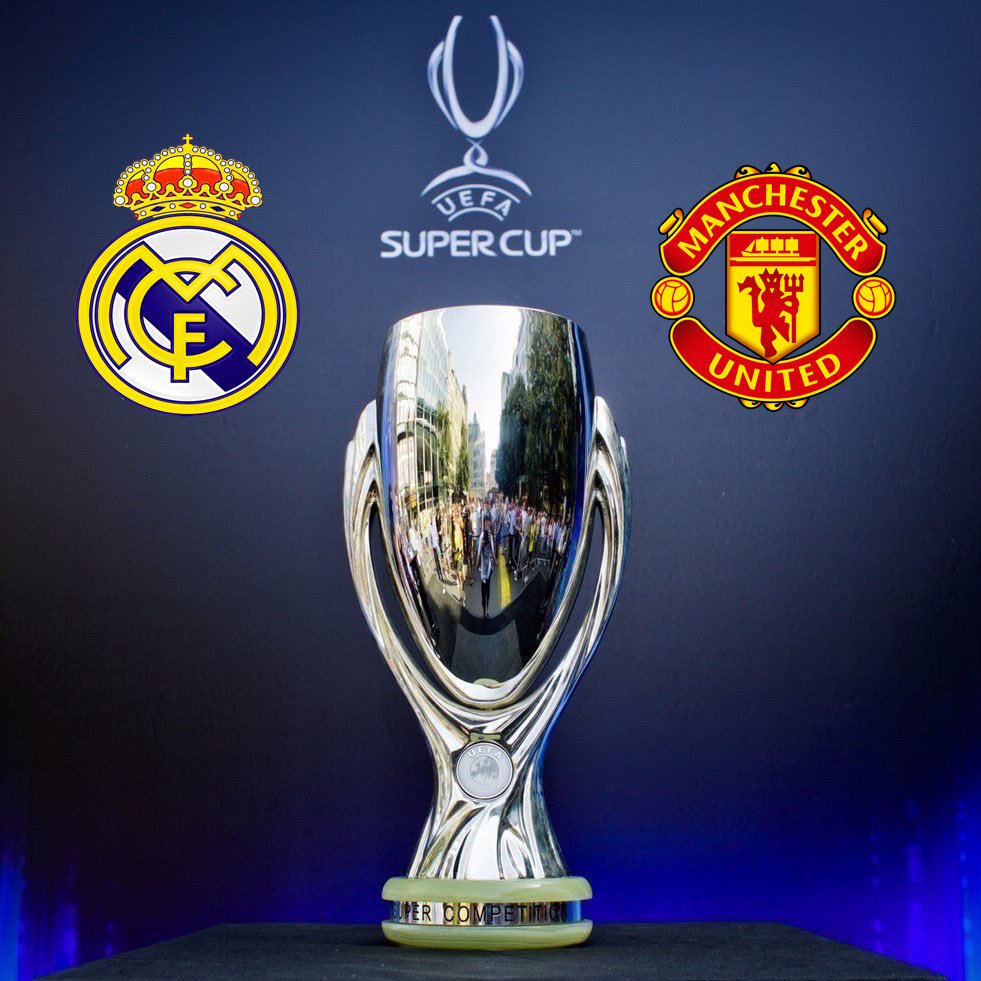

In [35]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image, width =300)
display(pil_img)

As you can see, this photo contains the logos of the Real Madrid football club, Manchester United football club, and the UEFA super cup. Clearly, the key information of the tweet sentence is coded here in a different modality.

## Training
Now let’s fit the predictor with the training data.
Firstly, we need to specify the problem_type to **ner**. 
As our annotations are used for text columns, to ensure the model to locate the correct text column for entity extraction, 
we need to set the corresponding column type to `text_ner` using the **column_types** parameter in cases where multiple text columns are present.
Here we set a tight time budget for a quick demo.

In [36]:
from autogluon.multimodal import MultiModalPredictor
import uuid

label_col = "entity_annotations"
model_path = f"./tmp/{uuid.uuid4().hex}-automm_multimodal_ner"
predictor = MultiModalPredictor(problem_type="ner", label=label_col, path=model_path)
predictor.fit(
	train_data=train_data,
	column_types={"text_snippet":"text_ner"},
	# time_limit=60*60*2, #second
	time_limit=300, #second
)

=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          16
Pytorch Version:    2.0.0.post104
CUDA Version:       CUDA is not available
Memory Avail:       34.95 GB / 64.00 GB (54.6%)
Disk Space Avail:   468.22 GB / 931.55 GB (50.3%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/multimodal_prediction/tmp/84309d684127464abe5826d32a6bf773-automm_multimodal_ner
    ```

INFO: Global seed set to 0
GPU Count: 0
GPU Count to be Used: 0

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU co

Epoch 0:   4%|▍         | 14/360 [04:48<1:58:54, 20.62s/it]                

INFO: Time limit reached. Elapsed time is 0:05:09. Signaling Trainer to stop.


Epoch 0:   4%|▍         | 15/360 [05:09<1:58:48, 20.66s/it]
Validation: 0it [00:00, ?it/s]
Epoch 0:   4%|▍         | 15/360 [11:52<4:33:07, 47.50s/it]             


AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/multimodal_prediction/tmp/84309d684127464abe5826d32a6bf773-automm_multimodal_ner")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Under the hood, AutoMM automatically detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models.
If multiple backbones are available, AutoMM appends a late-fusion model on top of them.

## Evaluation

In [37]:
predictor.evaluate(test_data,  metrics=['overall_recall', "overall_precision", "overall_f1"])

Predicting DataLoader 0: 100%|██████████| 23/23 [09:15<00:00, 24.15s/it]


{'overall_recall': 0.08284883720930232,
 'overall_precision': 0.016615653694796676,
 'overall_f1': 0.027679980575452227}

## Prediction

You can easily obtain the predictions by calling predictor.predict().

In [38]:
prediction_input = test_data.drop(columns=label_col).head(1)
predictions = predictor.predict(prediction_input)
print('Tweet:', prediction_input.text_snippet[0])
print('Image path:', prediction_input.image[0])
print('Predicted entities:', predictions[0])

for entity in predictions[0]:
	print(f"Word '{prediction_input.text_snippet[0][entity['start']:entity['end']]}' belongs to group: {entity['entity_group']}")

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
Tweet: Citifield Fan View : RT @ jehnnybgoode What a gorgeous day for baseball ! Stuck in that Saturdaze . # NewYorkMets VS # Sa …
Image path: /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/multimodal_prediction/ag_automm_tutorial_ner/multimodal_ner/twitter2017_images/16_05_01_360.jpg
Predicted entities: [{'entity_group': 'LOC', 'start': 0, 'end': 9}, {'entity_group': 'PER', 'start': 10, 'end': 13}, {'entity_group': 'PER', 'start': 14, 'end': 18}, {'entity_group': 'LOC', 'start': 21, 'end': 23}, {'entity_group': 'LOC', 'start': 26, 'end': 38}, {'entity_group': 'PER', 'start': 39, 'end': 43}, {'entity_group': 'PER', 'start': 46, 'end': 54}, {'entity_group': 'PER', 'start': 63, 'end': 73}, {'entity_group': 'LOC', 'start': 74, 'end': 79}, {'entity_group': 'PER', 'start': 80, 'end': 87}, {'entity_group': 'PER', 'start': 88, 'end': 97}, {'entity_group': 'PER', 'start': 98, 'end': 99},

## Reloading and Continuous Training

The trained predictor is automatically saved and you can easily reload it using the path.
If you are not satisfied with the current model performance, you can continue training the loaded model with new data.

In [39]:
new_predictor = MultiModalPredictor.load(model_path)
new_model_path = f"./tmp/{uuid.uuid4().hex}-automm_multimodal_ner_continue_train"
new_predictor.fit(train_data, time_limit=60, save_path=new_model_path)
test_score = new_predictor.evaluate(test_data, metrics=['overall_f1'])
print(test_score)

ValueError: Resuming checkpoint '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/multimodal_prediction/tmp/84309d684127464abe5826d32a6bf773-automm_multimodal_ner/last.ckpt' and final checkpoint '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/multimodal_prediction/tmp/84309d684127464abe5826d32a6bf773-automm_multimodal_ner/model.ckpt' both don't exist. Consider starting training from scratch.

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).